# Décorrélation des effets environnementaux

**Candidat :** Bryan Chen

**Date :** 01/12/2025

## 1. Contexte et Objectifs

Dans le cadre du monitoring d'ouvrages d'art (SHM), les mesures géométriques (déplacements) sont fortement impactées par les conditions environnementales (température, ensoleillement). Ces variations réversibles masquent souvent les phénomènes irréversibles liés au vieillissement de la structure.

**L'objectif** de ce notebook est de :
1. Charger et nettoyer les données brutes (`dataset.dat`).
2. Analyser les corrélations entre les variables.
3. Entraîner un modèle de régression pour estimer l'impact de l'environnement.
4. Soustraire cet impact pour obtenir un déplacement **décorrélé** (représentatif de la santé structurelle).

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Configuration du style des graphiques
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("Environnement chargé avec succès.")

Environnement chargé avec succès.


## 2. Chargement et Nettoyage des Données

Le fichier brut contient potentiellement des erreurs de formatage (chaines "NAN", séparateurs inconnus). Nous allons :
* Lire le fichier avec un moteur flexible.
* Convertir la colonne temporelle `TIMESTAMP`.
* Nettoyer les valeurs non-numériques dans les mesures.
* Utiliser le temps comme index pour faciliter les tracés temporels.

In [2]:
# Chemin du fichier
file_path = 'dataset.dat'

try:
    # 1. Lecture souple (détection automatique du séparateur)
    df = pd.read_csv(file_path, sep=None, engine='python')
    
    # 2. Nettoyage des noms de colonnes (suppression d'espaces, mise en minuscules)
    df.columns = df.columns.str.strip().str.lower()
    
    # 3. Conversion Temporelle
    # 'coerce' permet de gérer les dates mal formées en les transformant en NaT
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    
    # 4. Conversion Numérique
    # Gestion des "NAN" textuels : tout ce qui n'est pas un nombre devient NaN
    cols_numeriques = ['deplacement', 'ensoleillement', 'temperature']
    for col in cols_numeriques:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # 5. Indexation et suppression des données manquantes
    df.set_index('timestamp', inplace=True)
    initial_shape = df.shape
    df = df.dropna()
    
    print(f"Données chargées : {initial_shape[0]} lignes brutes.")
    print(f"Données nettoyées : {df.shape[0]} lignes valides.")
    print("-" * 30)
    print(df.head())

except Exception as e:
    print(f"Erreur critique : {e}")

Données chargées : 1848 lignes brutes.
Données nettoyées : 1761 lignes valides.
------------------------------
                     deplacement  ensoleillement  temperature
timestamp                                                    
2020-03-14 00:01:22          1.3             0.0     8.381906
2020-03-14 00:18:05          0.5             0.0     8.388235
2020-03-14 00:35:17          1.8             0.0     8.397227
2020-03-14 01:09:27          1.7             0.0     8.426197
2020-03-14 01:26:24          1.7             0.0     8.440569


## 3. Analyse Exploratoire (EDA)

Avant de modéliser, nous devons comprendre les relations entre nos variables.
Nous allons observer :
1. **La matrice de corrélation :** Pour quantifier le lien linéaire.
2. **Les séries temporelles :** Pour visualiser la dynamique des mesures.

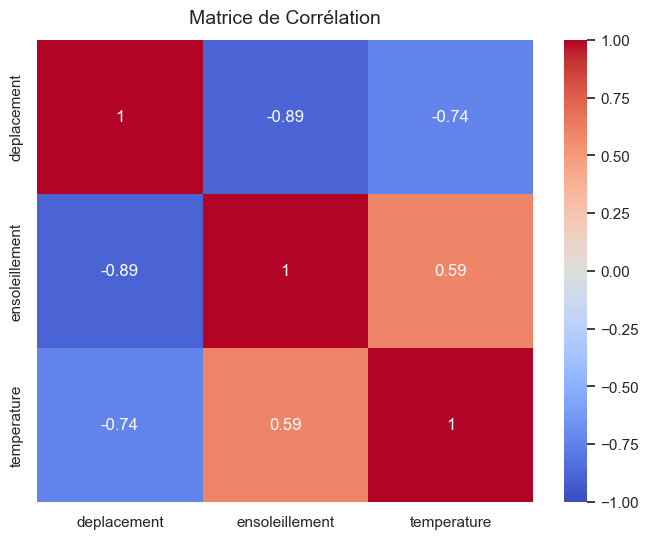

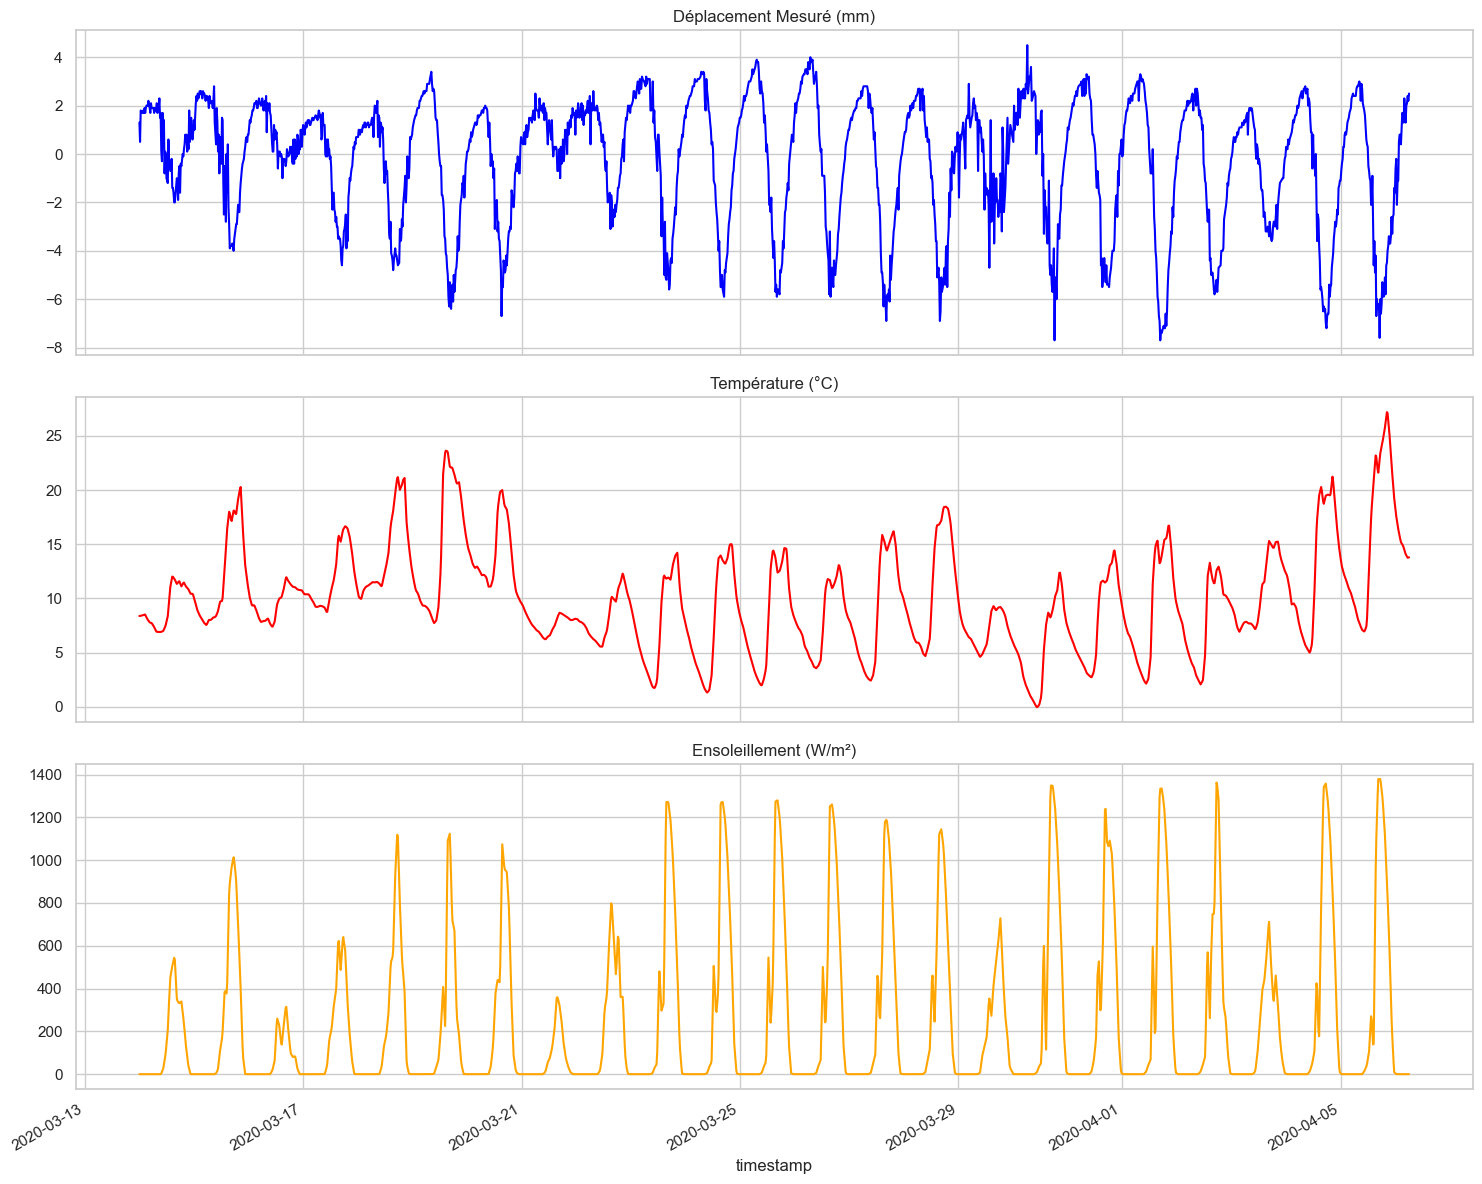

In [3]:
# 1. Matrice de corrélation
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
heatmap.set_title('Matrice de Corrélation', fontdict={'fontsize':14}, pad=12)
plt.show()

# 2. Visualisation des séries temporelles
fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

df['deplacement'].plot(ax=axes[0], color='blue', title='Déplacement Mesuré (mm)')
df['temperature'].plot(ax=axes[1], color='red', title='Température (°C)')
df['ensoleillement'].plot(ax=axes[2], color='orange', title='Ensoleillement (W/m²)')

plt.tight_layout()
plt.show()

### Analyse Qualitative
* **Forte corrélation négative** : On observe une corrélation de **-0.89** entre l'ensoleillement et le déplacement, et de **-0.74** avec la température.
* **Interprétation physique** : Lorsque la température augmente ou que le soleil tape, la structure se dilate, ce qui se traduit ici par un déplacement négatif sur le capteur.
* **Choix du modèle** : La relation semble fortement linéaire. Un modèle de **Régression Linéaire Multiple** est donc un excellent candidat pour commencer.

## 4. Modélisation et Décorrélation

Nous posons l'hypothèse suivante :
$$ Mesure_{totale}(t) = f(Temperature(t), Soleil(t)) + \epsilon(t) $$

Où :
* $f(...)$ représente le comportement élastique réversible (dilatation).
* $\epsilon(t)$ (le résidu) représente le **déplacement décorrélé**, c'est-à-dire le comportement intrinsèque de la structure (vieillissement).

Nous allons entraîner un modèle linéaire pour approximer $f$.

In [4]:
# Définition des variables
X = df[['temperature', 'ensoleillement']]
y = df['deplacement']

# Initialisation et entraînement du modèle linéaire
model = LinearRegression()
model.fit(X, y)

# Évaluation
r2 = model.score(X, y)
coeffs = model.coef_

print(f"Performance du modèle (R²) : {r2:.4f}")
print(f"Coefficients : Température = {coeffs[0]:.4f}, Ensoleillement = {coeffs[1]:.4f}")
print(f"Intercept (Ordonnée à l'origine) : {model.intercept_:.4f}")

Performance du modèle (R²) : 0.8576
Coefficients : Température = -0.1775, Ensoleillement = -0.0049
Intercept (Ordonnée à l'origine) : 2.7504


Avec un **$R^2$ de 0.86**, le modèle explique 86% de la variance du déplacement uniquement grâce aux variables météo. C'est un résultat très satisfaisant qui valide l'approche.

Nous allons maintenant calculer le déplacement décorrélé :
$$ Déplacement_{décorrélé} = Déplacement_{mesuré} - Prédiction_{modèle} $$

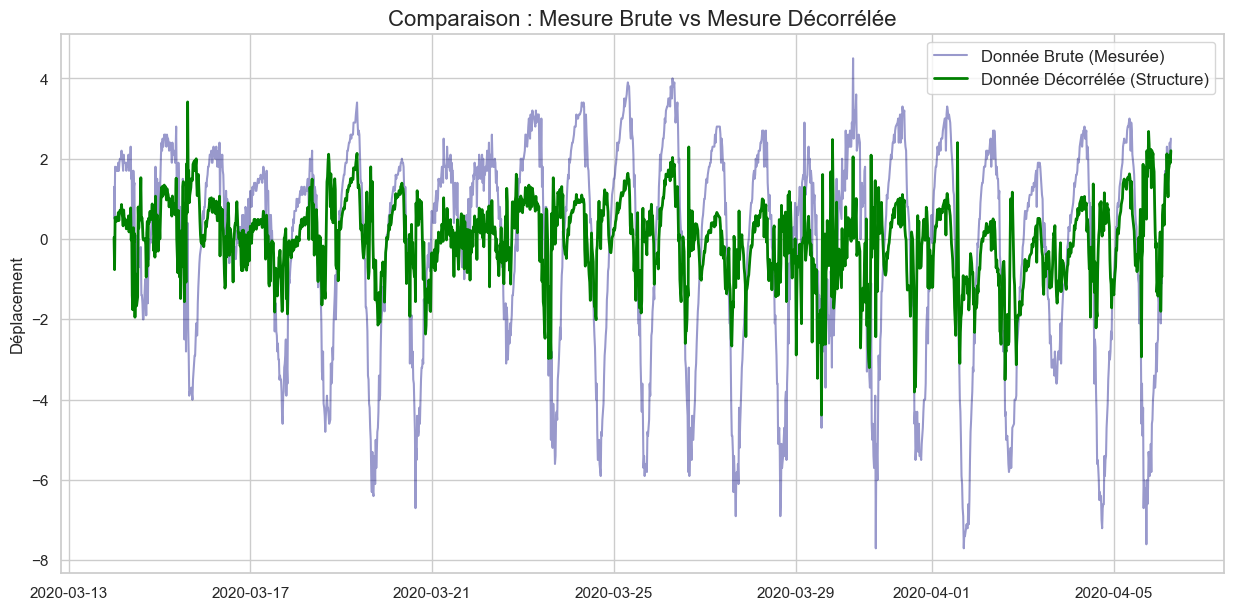

Fichier 'resultats_decorreles.csv' généré avec succès.


In [5]:
# Calcul de la prédiction (partie environnementale)
df['modele_environnement'] = model.predict(X)

# Calcul du résidu (partie structurelle décorrélée)
df['deplacement_decorrele'] = df['deplacement'] - df['modele_environnement']

# Visualisation comparative
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['deplacement'], label='Donnée Brute (Mesurée)', alpha=0.4, color='navy')
plt.plot(df.index, df['deplacement_decorrele'], label='Donnée Décorrélée (Structure)', color='green', linewidth=2)

plt.title('Comparaison : Mesure Brute vs Mesure Décorrélée', fontsize=16)
plt.legend(fontsize=12)
plt.ylabel('Déplacement')
plt.grid(True)
plt.show()

# Export des résultats
df.to_csv("resultats_decorreles.csv")
print("Fichier 'resultats_decorreles.csv' généré avec succès.")


## 5. Conclusion et Pistes d'amélioration

### Bilan
L'opération de décorrélation est un succès.
* La courbe brute (bleue) présente de fortes oscillations journalières.
* La courbe décorrélée (verte) est beaucoup plus stable et **plate**.
* **Diagnostic :** La courbe verte ne montre pas de dérive significative (tendance à la hausse ou la baisse) sur la période observée. La structure semble saine et se comporte de manière élastique face aux sollicitations thermiques.

### Pistes d'amélioration (Ouverture)
Pour aller plus loin et augmenter la précision du modèle (passer de $R^2=0.86$ à $>0.90$), nous pourrions explorer :

1.  **L'inertie thermique (Déphasage) :** Les structures massives en béton mettent du temps à chauffer. Le pic de déplacement arrive souvent 1 à 2 heures après le pic d'ensoleillement.
    *   *Solution :* Ajouter des features décalées (ex: `Temperature(t-1h)`, `Moyenne_Glissante_3h`).
2.  **Modèle HST (Hydrostatic-Seasonal-Time) :**
    *   Sur des périodes longues (plusieurs mois/années), il faut prendre en compte la saisonnalité (l'hiver diffère de l'été). L'ajout de fonctions sinusoïdales (cos/sin annuels) améliorerait la robustesse.
3.  **Non-linéarités :**
    *   Si les matériaux ont un comportement complexe, un modèle de type **Random Forest** ou un **Réseau de Neurones** pourrait capturer des interactions plus fines que la régression linéaire.